---
# Esercitazione 7
---
## Dinamica Molecolare con metodo Monte Carlo
In questa esercitazione viene svolta un'analisi analoga a quanto fatto per l'esercitazione 4 sulla Dinamica Molecolare; in questo caso il problema viene affrontato con metodo Monte Carlo e algoritmo di Metropolis.
L'utilizzo del metodo Monte Carlo permette di lavorare in un ensamble macrocanonico, campionando $\textit{a temperatura fissata}$ la distribuzione aspettata delle varie particelle; per questo motivo il problema è chiamato NVT, in cui sono fissati il numero di particelle N, il volume V in cui si muovono e la temperatura T. In precedenza, il problema della dinamica molecolare è stato affrontato analizzando le singole traiettorie delle varie particelle, lavorando dunque in un ensamble microcanonico, chiamato NVE in quanto era l'energia del sistema ad essere costante. 

Come per l'esercitazione $4$, si lavora in unità ridotte di Lennard-Jones, ovvero considerando la distanza, l'energia e la temperatura in unità rispettivamente di $\sigma$, $\epsilon$ e $\epsilon/k_B$ (con $k_B$ costante di Boltzmann, ovvero si lavora anche in unità di massa). I tre stati di aggregazione sono li stessi già studiati, relativi alle seguenti condizioni:

- Fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (Raggio di cut-off: $r_c = 2.2$)
- Fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (Raggio di cut-off: $r_c = 2.5$)
- Fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (Raggio di cut-off: $r_c = 5.0$)

## Esercizio 07.1
Nel primo punto di questa esercitazione vengono implementate le Tail Corrections al calcolo dell'energia potenziale e della pressione. Queste correzioni sono dovute all'utilizzo del raggio di taglio $r_{cut}$, utilizzato in precedenza per semplificare il problema del raggio d'interazione tra particelle vicine. Le correzioni di coda considerano il contributo dato a energia e pressione dall'interazione per $r> r_{cut}$, considerando che in questa regione le interazioni diventano più deboli e la situazione è indistinguibile da un gas ideale, sia per lo stato liquido che per quello solido. Per il potenziale di Lennard-Jones e la pressione associata tali correzioni diventano:

$$
\langle V \rangle _{Tail} = \dfrac{8}{3} \pi \rho \left[\dfrac{1}{3} \left(\dfrac{\sigma}{r_{cut}} \right)^9 -\left(\dfrac{\sigma}{r_{cut}} \right)^3 \right] \cdot N
$$
$$
\langle P \rangle _{Tail} = \dfrac{32}{3} \pi \rho \left[\dfrac{1}{3} \left(\dfrac{\sigma}{r_{cut}} \right)^9 -\dfrac{1}{2} \left(\dfrac{\sigma}{r_{cut}} \right)^3 \right] \cdot \rho
$$

Per questo motivo, e per completezza, tali correzioni sono implementate anche nel calcolo dell'energia subìta da una particella, utilizzata per campionare la distribuzione di Boltzmann con algoritmo di Metropolis. Tuttavia, quest'ultima non è necessaria perché si lavora con differenze di energia, quindi la correzione si semplifica.

## Esercizio 07.2
Nel secondo punto viene mostrato l'andamento dell'energia interna media per particella, al variare di $5\cdot 10^5$ step MC. Grazie a questo studio, analizzando l'autocorrelazione, sarà possibile stabilire il miglior numero di blocchi da utilizzare per ridurre l'errore. Ovvero, guardo la correlazione tra le variabili, osservo dopo quanti step si decorrelano e poi scelgo i blocchi in modo che siano molto più grandi di questi step.

### Equilibrazione
Prima di effettuare la misura istantanea dell'energia interna è necessario analizzare il suo andamento a partire dalla configurazione iniziale, per capire il tempo MC necessario per equilibrare il sistema. Per garantire il corretto utilizzo dell'algoritmo di Metropolis è anche necessario impostare un giusto valore per il parametro $\delta$ utilizzato per l'estrazione di valori casuali in modo uniforme. In analogia con l'esercizio 5, la probabilità di transizione è uniforme e il valore casuale della posizione è estratto in un range pari a $[-{\delta\over 2}, +{\delta\over 2}]$ per ogni coordinata $(x, y, z)$, centrata nella posizione vecchia. I valori ottimali di $\delta$ sono quelli per la quale si raggiunge un valore di accettazione il più vicino possibile al $50\%$ nella fase di misurazione. Per i tre stati di aggregazione si sono trovati i seguenti valori:
- 0.112 per la fase solida, con accettazione $0.5009$
- 0.206 per la fase liquida, con accettazione $0.5047$
- 10 per la fase gassosa, con accettazione $0.6161$

Per lo stato gassoso si nota che non è possibile raggiungere il valore di accettazione desiderato. L'elevato disordine dello stato macrocanonico fa sì che sia necessario un valore di $\delta$ molto elevato. In questo caso si è scelto un valore limite pari a quello che garantisce una scelta di dati casuali uniformi in $[-r_c ; +r_c]$ (dove per lo stato gassoso si ha infatti $r_c = 5$).

Di seguito è riportato l'andamento dell'energia interna per i primi $1000$ step nei diversi stati di aggregazione (la temperatura è invece ovviamente costante) ottenuto con l'algoritmo NVT. I dati sono confrontati con gli stessi andamenti ma ottenuti in assenza di tail corrections.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# carico l'energia misurata nei tre stati
E_sol = np.loadtxt("./Solido/NVT/Equilibration_U-N.dat", unpack= True, usecols=(0), skiprows=0)
E_liq = np.loadtxt("./Liquido/NVT/Equilibration_U-N.dat", unpack= True, usecols=(0), skiprows=0)
E_gas = np.loadtxt("./Gas/NVT/Equilibration_U-N.dat", unpack= True, usecols=(0), skiprows=0)

# carico anche i valori di equilibrazione in assenza di tail corrections
E_sol_notail = np.loadtxt("./Solido/NVT/Equilibration_U-N_notail.dat", unpack= True, usecols=(0), skiprows=0)
E_liq_notail = np.loadtxt("./Liquido/NVT/Equilibration_U-N_notail.dat", unpack= True, usecols=(0), skiprows=0)
E_gas_notail = np.loadtxt("./Gas/NVT/Equilibration_U-N_notail.dat", unpack= True, usecols=(0), skiprows=0)

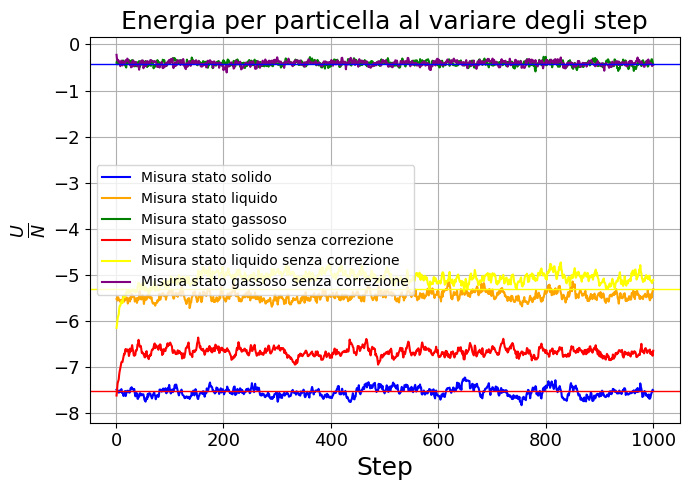

Differenza percentuale correzione stato solido: 13.108%
Differenza percentuale correzione stato liquido: 3.968%
Differenza percentuale correzione stato gassoso: -2.242%


In [5]:
N = len(E_sol)           # numero di step
x = np.arange(1, N+1)   # x del grafico, numero di step: [1,2,...,Nstep]

plt.figure(figsize=(7, 5))
plt.title(r"Energia per particella al variare degli step",fontsize=18)

plt.plot(x, E_sol, label = "Misura stato solido", color = "blue") # plotto
plt.plot(x, E_liq, label = "Misura stato liquido", color = "orange") # plotto
plt.plot(x, E_gas, label = "Misura stato gassoso", color = "green") # plotto

plt.plot(x, E_sol_notail, label = "Misura stato solido senza correzione", color = "red") # plotto
plt.plot(x, E_liq_notail, label = "Misura stato liquido senza correzione", color = "yellow") # plotto
plt.plot(x, E_gas_notail, label = "Misura stato gassoso senza correzione", color = "purple") # plotto

plt.xlabel(r"Step", fontsize=18)
plt.ylabel(r"$\frac{U}{N}$", fontsize=18)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.axhline(y=E_sol[-1], xmin=0, xmax=1, lw = 1, color = 'red')
plt.axhline(y=E_liq[-1], xmin=0, xmax=1, lw = 1, color = 'yellow')
plt.axhline(y=E_gas[-1], xmin=0, xmax=1, lw = 1, color = 'blue')

plt.legend(prop={'size': 10}) #, loc='lower right', )

plt.grid(True)
plt.tight_layout() # per ridurre lo spazio bianco intorno

plt.show()

print(f"Differenza percentuale correzione stato solido: {-100*(E_sol_notail[-1]-E_sol[-1])/E_sol_notail[-1]:.3f}%")
print(f"Differenza percentuale correzione stato liquido: {-100*(E_liq_notail[-1]-E_liq[-1])/E_liq_notail[-1]:.3f}%")
print(f"Differenza percentuale correzione stato gassoso: {-100*(E_gas_notail[-1]-E_gas[-1])/E_gas_notail[-1]:.3f}%")


Come è possibile notare, nei casi di aggregazione in stato solido e liquido le correzioni di coda forniscono un contributo positivo al valore dell'energia, indicando appunto che il suo valore è sottostimato in assenza di esse. Il caso gassoso, oltre ad essere il modulo minore agli altri e quindi indicare meno correzione, fornisce un contributo negativo, ciò indica il fatto che l'energia in questo caso è sovrastimata. Il caso particolare del gas era prevedibile, infatti l'ipotesi del contributo delle correzioni di coda si basa sul trattare interazioni lontane dalle particelle come se esse fossero parte di un gas. Per questo motivo si ha uno shift maggiore per stati più legati, dove il potenziale assume un valore maggiore e dunque troncarlo garantisce un errore più elevato.

In [6]:
# Ora calcolo la differenza teorica di pressione ed energia corretti e non

# funzione per calcolare le correzioni
def Potential_tail_correction(rho, rcut):
  return (8./3.) * np.pi * rho *( 1./(3. * rcut**9) - 1./rcut**3)

def Pressure_tail_correction(rho, rcut):
  return (32./3.) * np.pi * rho * ( 1./(3.* rcut**9) - 1./(2.*rcut**3) ) * rho

# creo un dizionario in cui le chiavi sono li stati di aggregazione e i valori sono liste con rho e rcut di ognuno
states = {
  "solid": [1.1, 2.2],
  "liquid": [0.8, 2.5],
  "gas": [0.05, 5],
}

# creo un dizionario vuoto in cui salvare per ogni stato la correzione sul potenziale e sulla pressione
tails = {}

for state in states:
  vtail = Potential_tail_correction(*states[state]) # unpack degli ingressi
  ptail = Pressure_tail_correction(*states[state])
  tails[state] = [vtail, ptail]

for state in tails:
  print(f"{state} state \n potential tail: {tails[state][0]:.3f}, pressure tail: {tails[state][1]:.4f}")


solid state 
 potential tail: -0.863, pressure tail: -1.8928
liquid state 
 potential tail: -0.428, pressure tail: -0.6844
gas state 
 potential tail: -0.003, pressure tail: -0.0003


Dagli andamenti è possibile notare che l'equilibrio viene raggiunto da tutti e tre li stati di aggregazione dopo circa $200$ step. Le linee continue sono prese come riferimento e sono associate all'utlimo valore dei tre dataset. Si nota inoltre che il valore all'equilibrio dell'energia interna è crescente con lo stato di aggregazione. Infatti, a temperatura fissata, i legami più forti garantiscono un'energia interna maggiore (in valore assoluto). Ciò è in opposizione con il fatto che si aggiunge il contributo dato dalla temperatura scelta, crescente nei tre stati; tuttavia per le temperature assegnate prevale il primo aspetto.

Per notare meglio l'andamento dell'energia istantanea vengono qui riportati i grafici con le correzioni, riducendo li step iniziali a $500$.

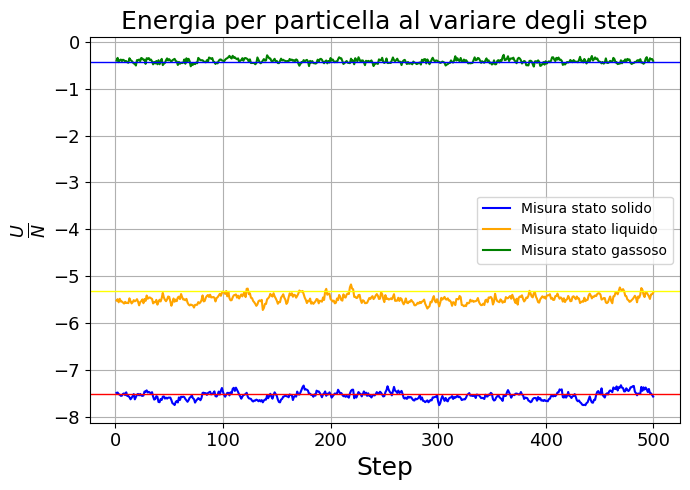

In [7]:
x = x[0:500]
plt.figure(figsize=(7, 5))
plt.title(r"Energia per particella al variare degli step",fontsize=18)

plt.plot(x, E_sol[0:500], label = "Misura stato solido", color = "blue") # plotto
plt.plot(x, E_liq[0:500], label = "Misura stato liquido", color = "orange") # plotto
plt.plot(x, E_gas[0:500], label = "Misura stato gassoso", color = "green") # plotto

plt.xlabel(r"Step", fontsize=18)
plt.ylabel(r"$\frac{U}{N}$", fontsize=18)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.axhline(y=E_sol[-1], xmin=0, xmax=1, lw = 1, color = 'red')
plt.axhline(y=E_liq[-1], xmin=0, xmax=1, lw = 1, color = 'yellow')
plt.axhline(y=E_gas[-1], xmin=0, xmax=1, lw = 1, color = 'blue')

plt.legend(prop={'size': 10}) #, loc='lower right', )

plt.grid(True)
plt.tight_layout() # per ridurre lo spazio bianco intorno

plt.show()

Si osserva quanto precedentemente notato: l'equilibrio è raggiunto dopo circa $200$ step.

### Autocorrelazione
Per ogni stato di aggregazione, dopo aver equilibrato il sistema con il valore di step trovato prima, viene generato un unico blocco da $5 \cdot 10^5$ dati di $U/N$ misurati. Da questi, si procede a calcolare la funzione di autocorrelazione al variare della loro distanza (in step). Essa permette di stimare dopo quanti step gli elementi di un dataset ${x}$ diventano indipendenti tra loro, ovvero si decorrelano. Un set di dati autocorrelati indica che elementi a step successivi sono dipendenti dalla storia passata. Infatti, la funzione di autocorrelazione è utilizzata in statistica per determinare se esistono pattern o regolarità interne nei dati.

L'autocorrelazione tra un dataset ${x}$ e se stesso ma shifato di una quantità $\tau$, chiamato "lag" o tempo di decorrelazione $t_c$, è così definita:

$$
AC_{[x]} = \dfrac{ \text{cov}_{[x,x]}(t, t+\tau) } { \text{cov}_{[x,x]}(t, t) }
$$

dove

$$
\text{cov}_{[x,x]}(t, t+\tau) = \langle x(t)\cdot x(t+\tau) \rangle - \langle x(t) \rangle \cdot \langle x(t+\tau) \rangle
$$

e quindi il denominatore si traduce nella semplice varianza del dataset. La presenza di autocorrelazione ed es. positiva indica che i valori della serie temporale a distanza $\tau$ tendono a muoversi nella stessa direzione; autocorrelazione negativa indica l'opposto.$\\$

Un'altra tecnica statistica che utilizza l'autocorrelazione è lo $\textit{Sparse Averaging}$. In questo caso per il calcolo della media di un'osservabile si utilizzano solo i dati a distanza $t_c$ o $2t_c$, ignorando quelli intermedi. In questo modo si hanno eventi tutti scorrelati e vale il teorema del limite centrale (l'incertezza statistica è la deviazione standard della media). Questa tecnica viene utilizzata nei casi in cui si ha molta richiesta computazionale.

Di seguito è riportato l'andamento dell'autocorrelazione del dataset dell'energia per particella al variare degli step temporali, da $0$ a $500$, il tutto svolto per i tre stati di aggregazione.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# carico l'energia misurata nei tre stati, DOPO l'equilibrazione
# i file si chiamano così perché li uso per calcolare l'autocorrelazione, ma sono misure di energia
eqE_sol = np.loadtxt("./Solido/NVT/Autocorrelation_U-N.dat", unpack= True, usecols=(0), skiprows=0)
eqE_liq = np.loadtxt("./Liquido/NVT/Autocorrelation_U-N.dat", unpack= True, usecols=(0), skiprows=0)
eqE_gas = np.loadtxt("./Gas/NVT/Autocorrelation_U-N.dat", unpack= True, usecols=(0), skiprows=0)

def autocorrelation(x: np.ndarray, nsteps: int):
    """
    Funzione di autocorrelazione di un dataset x con lag pari nsteps
    """
    x = np.array(x)
    ac = np.zeros(nsteps)   # preparo lo spazio per salvare i valori dell'autocorrelazione al variare della traslazione
    var = np.var(x)         # varianza del processo, serve a normalizzare l'autocorrelazione
    
    ac[0] = 1   # autocorrelazione senza shift, so che fa 1. Il range sotto devo farlo partire da 1 altrimenti ho problemi a fare x[:0]
    for tau in range(1, nsteps):   # calcolo l'autocorrelazione per diverse traslazioni tau
        mean1 = np.mean(x[:-tau]*x[tau:]) # <x(t)*x(t+tau)>
        mean2 = np.mean(x[:-tau])
        mean3 = np.mean(x[tau:])
        ac[tau] = (mean1 - mean2 * mean3) / var
        
    return ac

# calcolo già qui l'autocorrelazione, almeno per rifare il grafico non devo ricalcolare tutto ogni volta
nstep = 500 # valore massimo di tau da controllare
x = np.arange(nstep+1) # tutti i valori di tau per cui calcolare l'autocorrelazione, incluso il 500esimo step

autoc_sol = autocorrelation(eqE_sol, nstep+1) # aggiungo 1 perché includo anche il 500esimo step
autoc_liq = autocorrelation(eqE_liq, nstep+1)
autoc_gas = autocorrelation(eqE_gas, nstep+1)

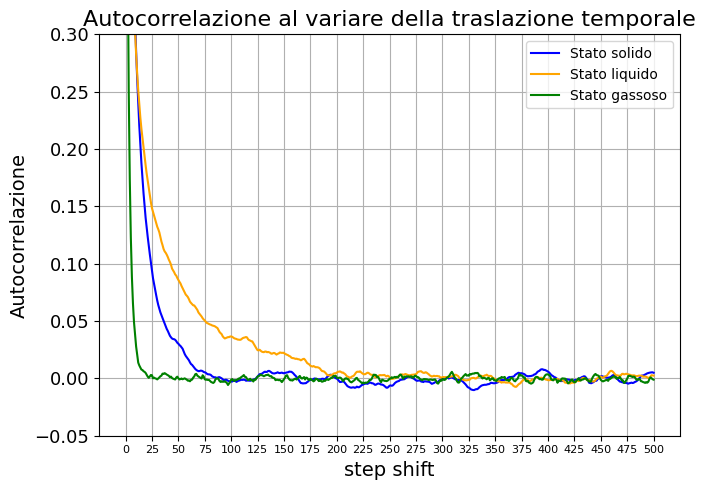

In [5]:
plt.figure(figsize=(7, 5))
plt.title(r"Autocorrelazione al variare della traslazione temporale", fontsize=16)

plt.plot(x, autoc_sol, label = "Stato solido", color = "blue") # plotto
plt.plot(x, autoc_liq, label = "Stato liquido", color = "orange") # plotto
plt.plot(x, autoc_gas, label = "Stato gassoso", color = "green") # plotto

plt.ylim(-0.05,0.3)

plt.xlabel(r"step shift", fontsize=14)
plt.ylabel(r"Autocorrelazione", fontsize=14)
plt.xticks(fontsize = 8, ticks = np.arange(0, 501, 25))
plt.yticks(fontsize = 13)

plt.legend(prop={'size': 10}) #, loc='lower right', )

plt.grid(True)
plt.tight_layout()

plt.show()

Dal risultato ottenuto (in cui per comodità si è ridotta la visualizzazione dell'autocorrelazione al solo intervallo $[0, 0.3]$) si può notare che, come previsto, al crescere della traslazione temporale si riduce l'autocorrelazione dei 3 dataset. In particolare, essa è approssimativamente compatibile con zero per i seguenti valori di shift:
- Stato gassoso: 50 step
- Stato solido: 125 step
- Stato liquido: 275 step

Questi risultati suggeriscono di utilizzare blocchi contenenti una quantità di dati (che chiameremo $L$) pari ad almento tali valori. In pratica, è utile aumentare un po' questa dimensione per essere sicuri di catturare tutta l'informazione correlata. Prossimamente viene proposto un criterio per scegliere il valore più appropriato dei dati per blocco da usare.

### Data Blocking
Ora si analizza l'andamento dell'incertezza statistica, degli stessi tre dataset analizzati in precedenza, al variare del numero di blocchi utilizzati. Più nello specifico, l'analisi verrà effettuata a partire da $L=10$ fino a $L=5000$ dati per blocco, il tutto a passi di $10$. Dato che il numero di dati per ogni set è fissato a $5 \cdot 10^{5}$, questo intervallo corrisponde a utilizzare un numero di blocchi da $N = 50000$ a $N = 100$. Di seguito sono mostrati i risultati.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# carico l'energia misurata nei tre stati, DOPO l'equilibrazione
eqE_sol = np.loadtxt("./Solido/NVT/Autocorrelation_U-N.dat", unpack= True, usecols=(0), skiprows=0)
eqE_liq = np.loadtxt("./Liquido/NVT/Autocorrelation_U-N.dat", unpack= True, usecols=(0), skiprows=0)
eqE_gas = np.loadtxt("./Gas/NVT/Autocorrelation_U-N.dat", unpack= True, usecols=(0), skiprows=0)

def error(x, L):
    """
    funzione che calcola l'errore di un dataset di valori, divisi a blocchi e contenenti ognuno L dati
    """
    M = len(x) # totale dati
    N = int(M/L) # numero di blocchi per quel valore di L fissato
    ave = [np.mean(x[int(i*L):int((i+1)*L)]) for i in range(N)] # lista contenente le medie sui blocchi
    error = np.sqrt( np.var(ave) / N ) # calcolo l'incertezza statistica delle medie sui blocchi
    return error

# calcolo già qui l'errore almeno per rifare il grafico non devo ricalcolare tutto ogni volta
x = np.arange(10, 5010, 10) # valori di L per cui calcolare l'errore, 10 e 5000 inclusi

error_sol = [error(eqE_sol, l) for l in x]
error_liq = [error(eqE_liq, l) for l in x]
error_gas = [error(eqE_gas, l) for l in x]



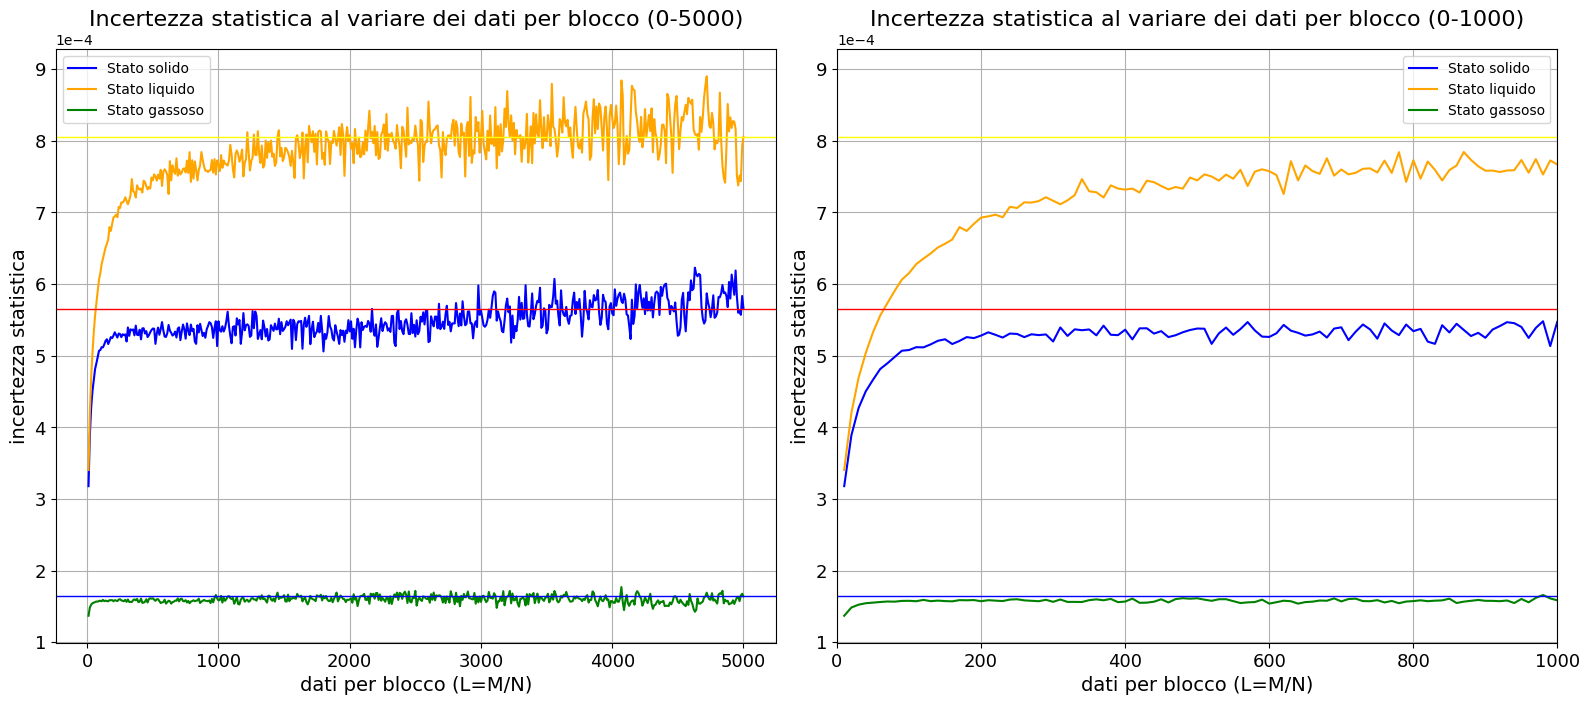

In [9]:
plt.figure(figsize=(16, 7))

plt.subplot(1,2,1)
plt.title(r"Incertezza statistica al variare dei dati per blocco (0-5000)",fontsize=16)

plt.plot(x, error_sol, label = "Stato solido", color = "blue") # plotto
plt.plot(x, error_liq, label = "Stato liquido", color = "orange") # plotto
plt.plot(x, error_gas, label = "Stato gassoso", color = "green") # plotto

plt.axhline(y=error_sol[-1], xmin=0, xmax=1, lw = 1, color = 'red')
plt.axhline(y=error_liq[-1], xmin=0, xmax=1, lw = 1, color = 'yellow')
plt.axhline(y=error_gas[-1], xmin=0, xmax=1, lw = 1, color = 'blue')

plt.xlabel(r"dati per blocco (L=M/N)", fontsize=14)
plt.ylabel(r"incertezza statistica", fontsize=14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

# plt.ylim(0.00012, 0.0002) # <- range errore stato liquido

plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.legend(prop={'size': 10}) #, loc='lower right', )

plt.grid(True)
plt.tight_layout()

##############################
plt.subplot(1,2,2)
plt.title(r"Incertezza statistica al variare dei dati per blocco (0-1000)",fontsize=16)

plt.xlim(0, 1000)
plt.plot(x, error_sol, label = "Stato solido", color = "blue") # plotto
plt.plot(x, error_liq, label = "Stato liquido", color = "orange") # plotto
plt.plot(x, error_gas, label = "Stato gassoso", color = "green") # plotto
plt.axhline(y=error_sol[-1], xmin=0, xmax=1, lw = 1, color = 'red')
plt.axhline(y=error_liq[-1], xmin=0, xmax=1, lw = 1, color = 'yellow')
plt.axhline(y=error_gas[-1], xmin=0, xmax=1, lw = 1, color = 'blue')
plt.xlabel(r"dati per blocco (L=M/N)", fontsize=14)
plt.ylabel(r"incertezza statistica", fontsize=14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
# plt.ylim(0.00012, 0.0002) # <- range errore stato liquido
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(prop={'size': 10}) #, loc='lower right', )
plt.grid(True)
plt.tight_layout()

plt.show()

I grafici superiori mostrano entrambi lo stesso errore al variare nel numero di dati per blocco, dove quello a sinistra arriva fino a $L=5000$ mentre quello a destra fino a $L=1000$. $\\$
Dai graifici è possibile osservare quanto aspettato, ovvero che l'errore al variare del numero di dati per blocco raggiunge un valore in cui satura. L'andamento osservato dipende dal fatto che nella fase iniziale, per un basso numero di dati per blocco e quindi con un numero eccessivo di blocchi, si sottostima l'errore. Un indicatore del numero di blocchi da utilizzare è il primo valore per cui si raggiunge questo valore. Il metodo a blocchi, infatti, permette di ridurre la correlazione tra i dati considerando come nuove variabili statistiche le medie trovate sui blocchi stessi. $\\$
Osservando l'errore nell'intervallo ridotto è possibile stimare che il numero di dati necessario per blocco per lo stato liquido è superiore a circa $1000$, per lo stato solido circa $300$ e per quello gassoso circa $100$. Per l'analisi successiva verrà preso $L = 1000$ dati per blocco per tutti gli stati di aggregazione. Si noti che tale valore è superiore al fattore di lag minimo necessario ad annullare la decorrelazione; inoltre, non è un numero di dati troppo elevato (corrisponde a $500$ blocchi) e quindi si continua ad avere una buona statistica.

## Esercizio 07.3
In questo punto si è implementato nel codice il calcolo della funzione di distribuzione radiale $g(r)$, con $r$ la distanza tra coppie di particelle, dove $r \in [0, L/2]$ con $L$ il lato del volume di riferimento della cella rappresentativa. La funzione di distribuzione radiale (o di coppia) è utile nel calcolo del valor medio di qualsiasi distribuzione che dipende da una coppia di particelle, o dalla loro posizione relativa in un sistema. $\\$
Tale funzione è la probabilità di trovare due particelle ad una certa distanza tra loro, rapportata con una probabilità uniforme. Questo significa che $g(r) \geq 0$ e che riflette la presenza di un potenziale d'interazione. Infatti, un'elevata distanza di separazione tra le particelle rende trascurabile il potenziale d'interazione, e quindi le forze tra esse, rendendo il sistema uniformemente distribuito. Per grandi distanze, dunque, $g(r) \simeq 1$, ovvero la probabilità con la quale si distribuiscono le particelle è uniforme, o analogamente la densità delle particelle tende al valore medio. Per questo motivo il calcolo analitico delle tail corrections viene fatto assumendo proprio $g(r) \simeq 1$. <br>
A distanze intermedie il valore è diverso da $1$ ma oscilla attorno a quel valore; ciò è dovuto al fatto che le particelle tendono a disporsi in shell concentriche attorno a una particella. A brevi distanze, invece, gli effetti del potenziale comportano interazioni tra particelle non trascurabili, che causano densità diverse dal valor medio. Nel caso preso in esame, il potenziale di Lennard-Jones garantisce che per $r^* < 1$ si abbia $g(r)\simeq 0$, infatti prevalgono forze repulsive tra particelle che annullano la probabilità di trovarne a distanze così ridotte. $\\$ 
Per analizzare la funzione di distribuzione si è creato un'istogramma di $n_{bins}=500$ bin in cui viene divisa la distanza pari a $L/2$. Ciò significa che ogni bin rappresenta un intervallo di lunghezza pari a $\frac{(L/2)}{n_{bins}}$. Successivamente, per ogni elemento della cella rappresentativa calcolo la mutua distanza tra particelle; se questa distanza è minore di $L/2$ viene poi divisa per la larghezza di un bin in modo da capire in quale ricade. Il bin selezionato viene riempito con contributo due (infatti considero il contributo mutuo) e complessivamente si ha un istogramma completo. Tale istogramma viene poi normalizzato: il calcolo esplicito della funzione di distribuzione a coppie fornisce la seguente normalizzazione:

$$
Norm = \rho N_{part} \cdot \dfrac{4}{3}\pi \left[\left(r+dr \right)^3 -r^3 \right]
$$

dove $dr$ è la larghezza dei bin e $r$ e la distanza alla quale si sta valutando $g(r)$. A un dato valore di $r$, $g(r)$ indica la probabilità di trovare due particelle ad una distanza compresa tra $r$ e $r+dr$.

## Esercizio 07.4
In questo punto si procede a calcolare $g(r)$, $U/N$ e $P$ tramite modello di Lennard-Jones per un sistema di atomi di Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu), con le stesse condizioni enunciate all'inizio. Verrà mostrato un confronto tra i risultati nei due metodi utilizzati, NVT e NVE, ottenuti utilizzando i rispettivi step di equilibrazione e di misura, di cui per il secondo sono riportati nell'esercitazione $4$. Per un confronto corretto, i risultati di pressione ed energia per il metodo NVE vengono shiftati di una quantità pari alle rispettive tail corrections, questo perché sono valori costanti.

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# carico U/N, P, g(r) misurata nei tre stati, sia per NVE che per NVT 
T_U_sol, T_err_U_sol = np.loadtxt("./Solido/NVT/output_epot.dat", unpack= True, usecols=(2, 3), skiprows=0) # NVT
E_U_sol, E_err_U_sol = np.loadtxt("./Solido/NVE/output_epot.dat", unpack= True, usecols=(2, 3), skiprows=0) # NVE

T_P_sol, T_err_P_sol = np.loadtxt("./Solido/NVT/output_pressure.dat", unpack= True, usecols=(2, 3), skiprows=0) # NVT
E_P_sol, E_err_P_sol = np.loadtxt("./Solido/NVE/output_pressure.dat", unpack= True, usecols=(2, 3), skiprows=0) # NVE

# converto in unità SI
T = 120 # temperatura [K]
k_b = 1.380649e-23 # costante di Boltzmann [J/K]
sigma = 0.34e-9 # sigma [m]

dati_U_sol = [T_U_sol, T_err_U_sol, E_U_sol, E_err_U_sol]
dati_P_sol = [T_P_sol, T_err_P_sol, E_P_sol, E_err_P_sol]

for U in dati_U_sol:
  U *= T*k_b
for P in dati_P_sol:
  P *= T*k_b/sigma**3

T_r_sol, T_g_sol, T_err_g_sol = np.loadtxt("./Solido/NVT/output_g_r.dat", unpack= True, usecols=(1, 2, 3), skiprows=49699) # NVT
E_r_sol, E_g_sol, E_err_g_sol = np.loadtxt("./Solido/NVE/output_g_r.dat", unpack= True, usecols=(1, 2, 3), skiprows=49699) # NVE


# Ora calcolo la differenza teorica di pressione ed energia corretti e non
# funzione per calcolare le correzioni
def Potential_tail_correction(rho, rcut):
  return (8./3.) * np.pi * rho *( 1./(3. * rcut**9) - 1./rcut**3) * T*k_b

def Pressure_tail_correction(rho, rcut):
  return (32./3.) * np.pi * rho * ( 1./(3.* rcut**9) - 1./(2.*rcut**3) ) * rho * T*k_b/sigma**3

# creo un dizionario in cui le chiavi sono li stati di aggregazione e i valori sono liste con rho e rcut di ognuno
states = {
  "solid": [1.1, 2.2],
  "liquid": [0.8, 2.5],
  "gas": [0.05, 5],
}

# creo un dizionario vuoto in cui salvare per ogni stato la correzione sul potenziale e sulla pressione
tails = {}

for state in states:
  vtail = Potential_tail_correction(*states[state]) # unpack degli ingressi
  ptail = Pressure_tail_correction(*states[state])
  tails[state] = [vtail, ptail]


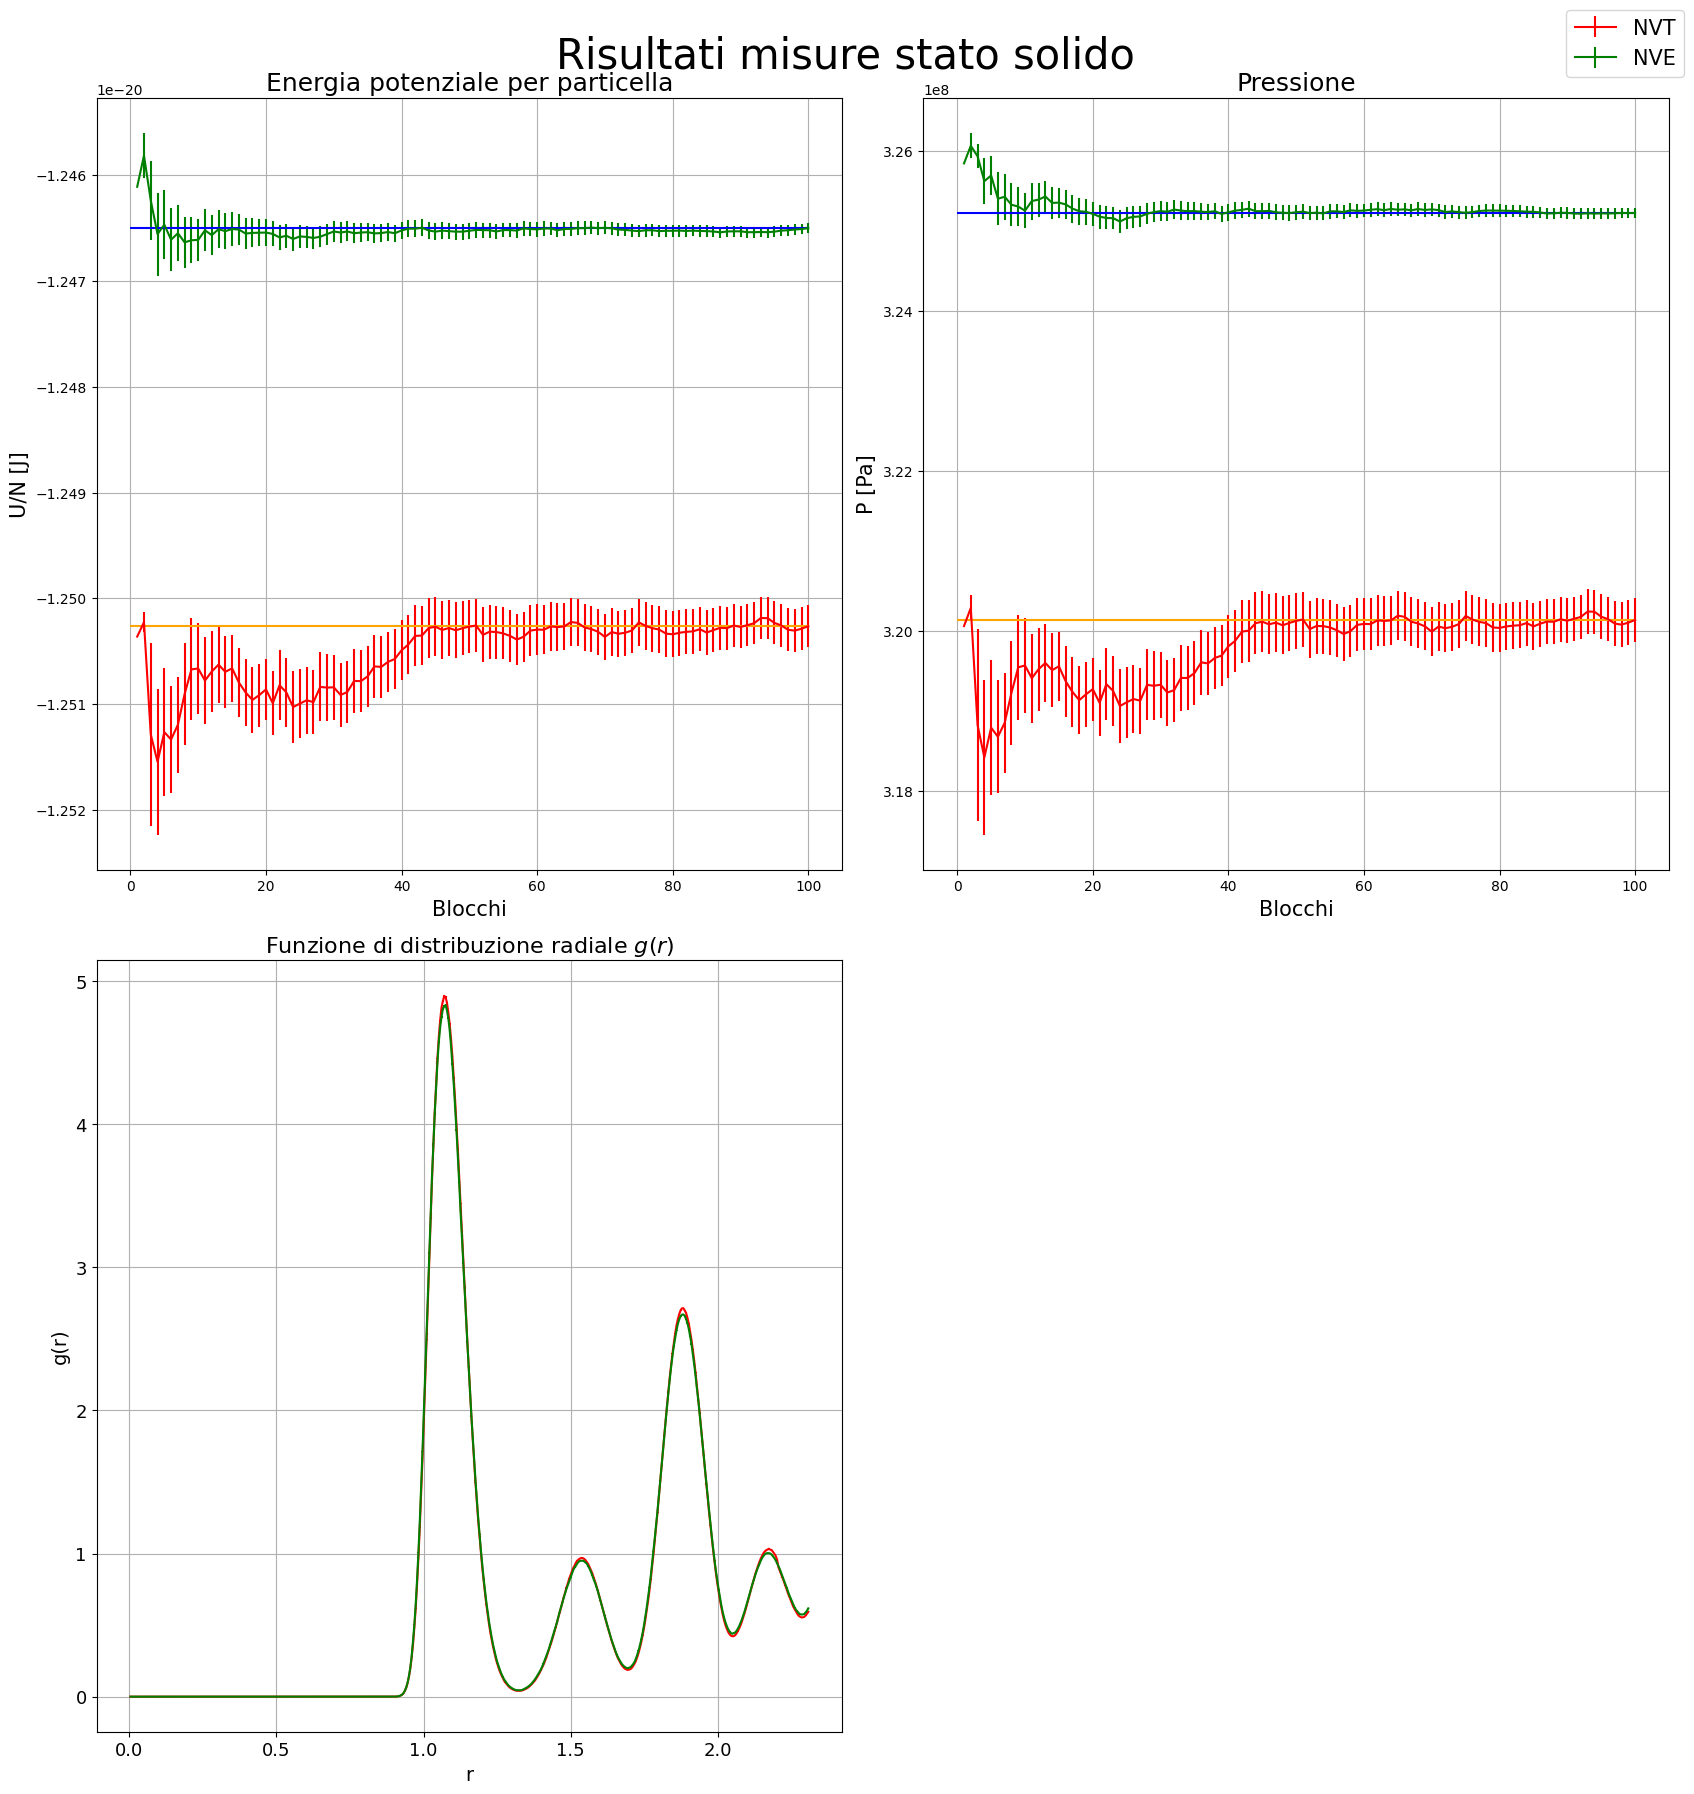

Differenza relativa energia NVE/NVT: -0.30 %
Differenza relativa pressione NVE/NVT: 1.59 %


In [11]:
N=len(T_U_sol) # number of blocks

# aggiungo le correzioni di coda a NVE
E_U_sol += tails["solid"][0]
E_P_sol += tails["solid"][1]

x = np.arange(1,N+1)

fig, axs = plt.subplots(2,2, figsize = (17,18))
fig.suptitle("Risultati misure stato solido", fontsize = (30))

plt.subplot(2,2,1)
plt.errorbar(x, T_U_sol, yerr=T_err_U_sol, label = "NVT", color = "red")
plt.errorbar(x, E_U_sol, yerr=E_err_U_sol, label = "NVE", color = "green")
plt.title("Energia potenziale per particella", fontsize=18)
plt.xlabel("Blocchi", fontsize = 15)
plt.ylabel("U/N [J]", fontsize = 15)
plt.hlines(T_U_sol[-1], 0, N, color = "orange")
plt.hlines(E_U_sol[-1], 0, N, color = "blue")
plt.grid(True)
plt.tight_layout()

plt.subplot(2,2,2)
plt.errorbar(x, T_P_sol, yerr=T_err_P_sol, color = "red")
plt.errorbar(x, E_P_sol, yerr=E_err_P_sol, color = "green")
plt.title("Pressione", fontsize=18)
plt.xlabel("Blocchi", fontsize = 15)
plt.ylabel("P [Pa]", fontsize = 15)
plt.hlines(T_P_sol[-1], 0, N, color = "orange")
plt.hlines(E_P_sol[-1], 0, N, color = "blue")
plt.grid(True)
plt.tight_layout()

plt.subplot(2,2,3)
plt.title(r"Funzione di distribuzione radiale $g(r)$",fontsize=16)
plt.errorbar(T_r_sol, T_g_sol, yerr=T_err_g_sol , color = "red")
plt.errorbar(E_r_sol, E_g_sol, yerr=E_err_g_sol , color = "green")
plt.xlabel(r"r", fontsize=14)
plt.ylabel(r"g(r)", fontsize=14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid(True)
plt.tight_layout()

plt.subplot(2,2,4)
plt.axis("off")

fig.legend(fontsize = 15)


plt.show()

print(f"Differenza relativa energia NVE/NVT: {100*((E_U_sol[-1]-T_U_sol[-1])/T_U_sol[-1]):.2f} %")
print(f"Differenza relativa pressione NVE/NVT: {100*((E_P_sol[-1]-T_P_sol[-1])/T_P_sol[-1]):.2f} %")


Come è possibile notare, i risultati ottenuti con i due metodi statistici NVE ed NVT sono compatibili. Questi dati mostrano la potenza del metodo Monte Carlo. $\\$
Osservando il grafico della distribuzione radiale si osserva che rispetta quanto aspettato, per grandi valori di $r$ oscilla in un intorno di $1$, per piccoli valori è nulla e per valori intermedi è diversa da $1$.

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# carico U/N, P, g(r) misurata nei tre stati, sia per NVE che per NVT 
T_U_liq, T_err_U_liq = np.loadtxt("./Liquido/NVT/output_epot.dat", unpack= True, usecols=(2, 3), skiprows=0) # NVT
E_U_liq, E_err_U_liq = np.loadtxt("./Liquido/NVE/output_epot.dat", unpack= True, usecols=(2, 3), skiprows=0) # NVE

T_P_liq, T_err_P_liq = np.loadtxt("./Liquido/NVT/output_pressure.dat", unpack= True, usecols=(2, 3), skiprows=0) # NVT
E_P_liq, E_err_P_liq = np.loadtxt("./Liquido/NVE/output_pressure.dat", unpack= True, usecols=(2, 3), skiprows=0) # NVE

# converto in unità SI
T = 120 # temperatura [K]
k_b = 1.380649e-23 # costante di Boltzmann [J/K]
sigma = 0.34e-9 # sigma [m]

dati_U_liq = [T_U_liq, T_err_U_liq, E_U_liq, E_err_U_liq]
dati_P_liq = [T_P_liq, T_err_P_liq, E_P_liq, E_err_P_liq]

for U in dati_U_liq:
  U *= T*k_b
for P in dati_P_liq:
  P *= T*k_b/sigma**3

T_r_liq, T_g_liq, T_err_g_liq = np.loadtxt("./Liquido/NVT/output_g_r.dat", unpack= True, usecols=(1, 2, 3), skiprows=49699) # NVT
E_r_liq, E_g_liq, E_err_g_liq = np.loadtxt("./Liquido/NVE/output_g_r.dat", unpack= True, usecols=(1, 2, 3), skiprows=49699) # NVE

# Ora calcolo la differenza teorica di pressione ed energia corretti e non
# funzione per calcolare le correzioni
def Potential_tail_correction(rho, rcut):
  return (8./3.) * np.pi * rho *( 1./(3. * rcut**9) - 1./rcut**3) * T*k_b

def Pressure_tail_correction(rho, rcut):
  return (32./3.) * np.pi * rho * ( 1./(3.* rcut**9) - 1./(2.*rcut**3) ) * rho * T*k_b/sigma**3

# creo un dizionario in cui le chiavi sono li stati di aggregazione e i valori sono liste con rho e rcut di ognuno
states = {
  "solid": [1.1, 2.2],
  "liquid": [0.8, 2.5],
  "gas": [0.05, 5],
}

# creo un dizionario vuoto in cui salvare per ogni stato la correzione sul potenziale e sulla pressione
tails = {}

for state in states:
  vtail = Potential_tail_correction(*states[state]) # unpack degli ingressi
  ptail = Pressure_tail_correction(*states[state])
  tails[state] = [vtail, ptail]


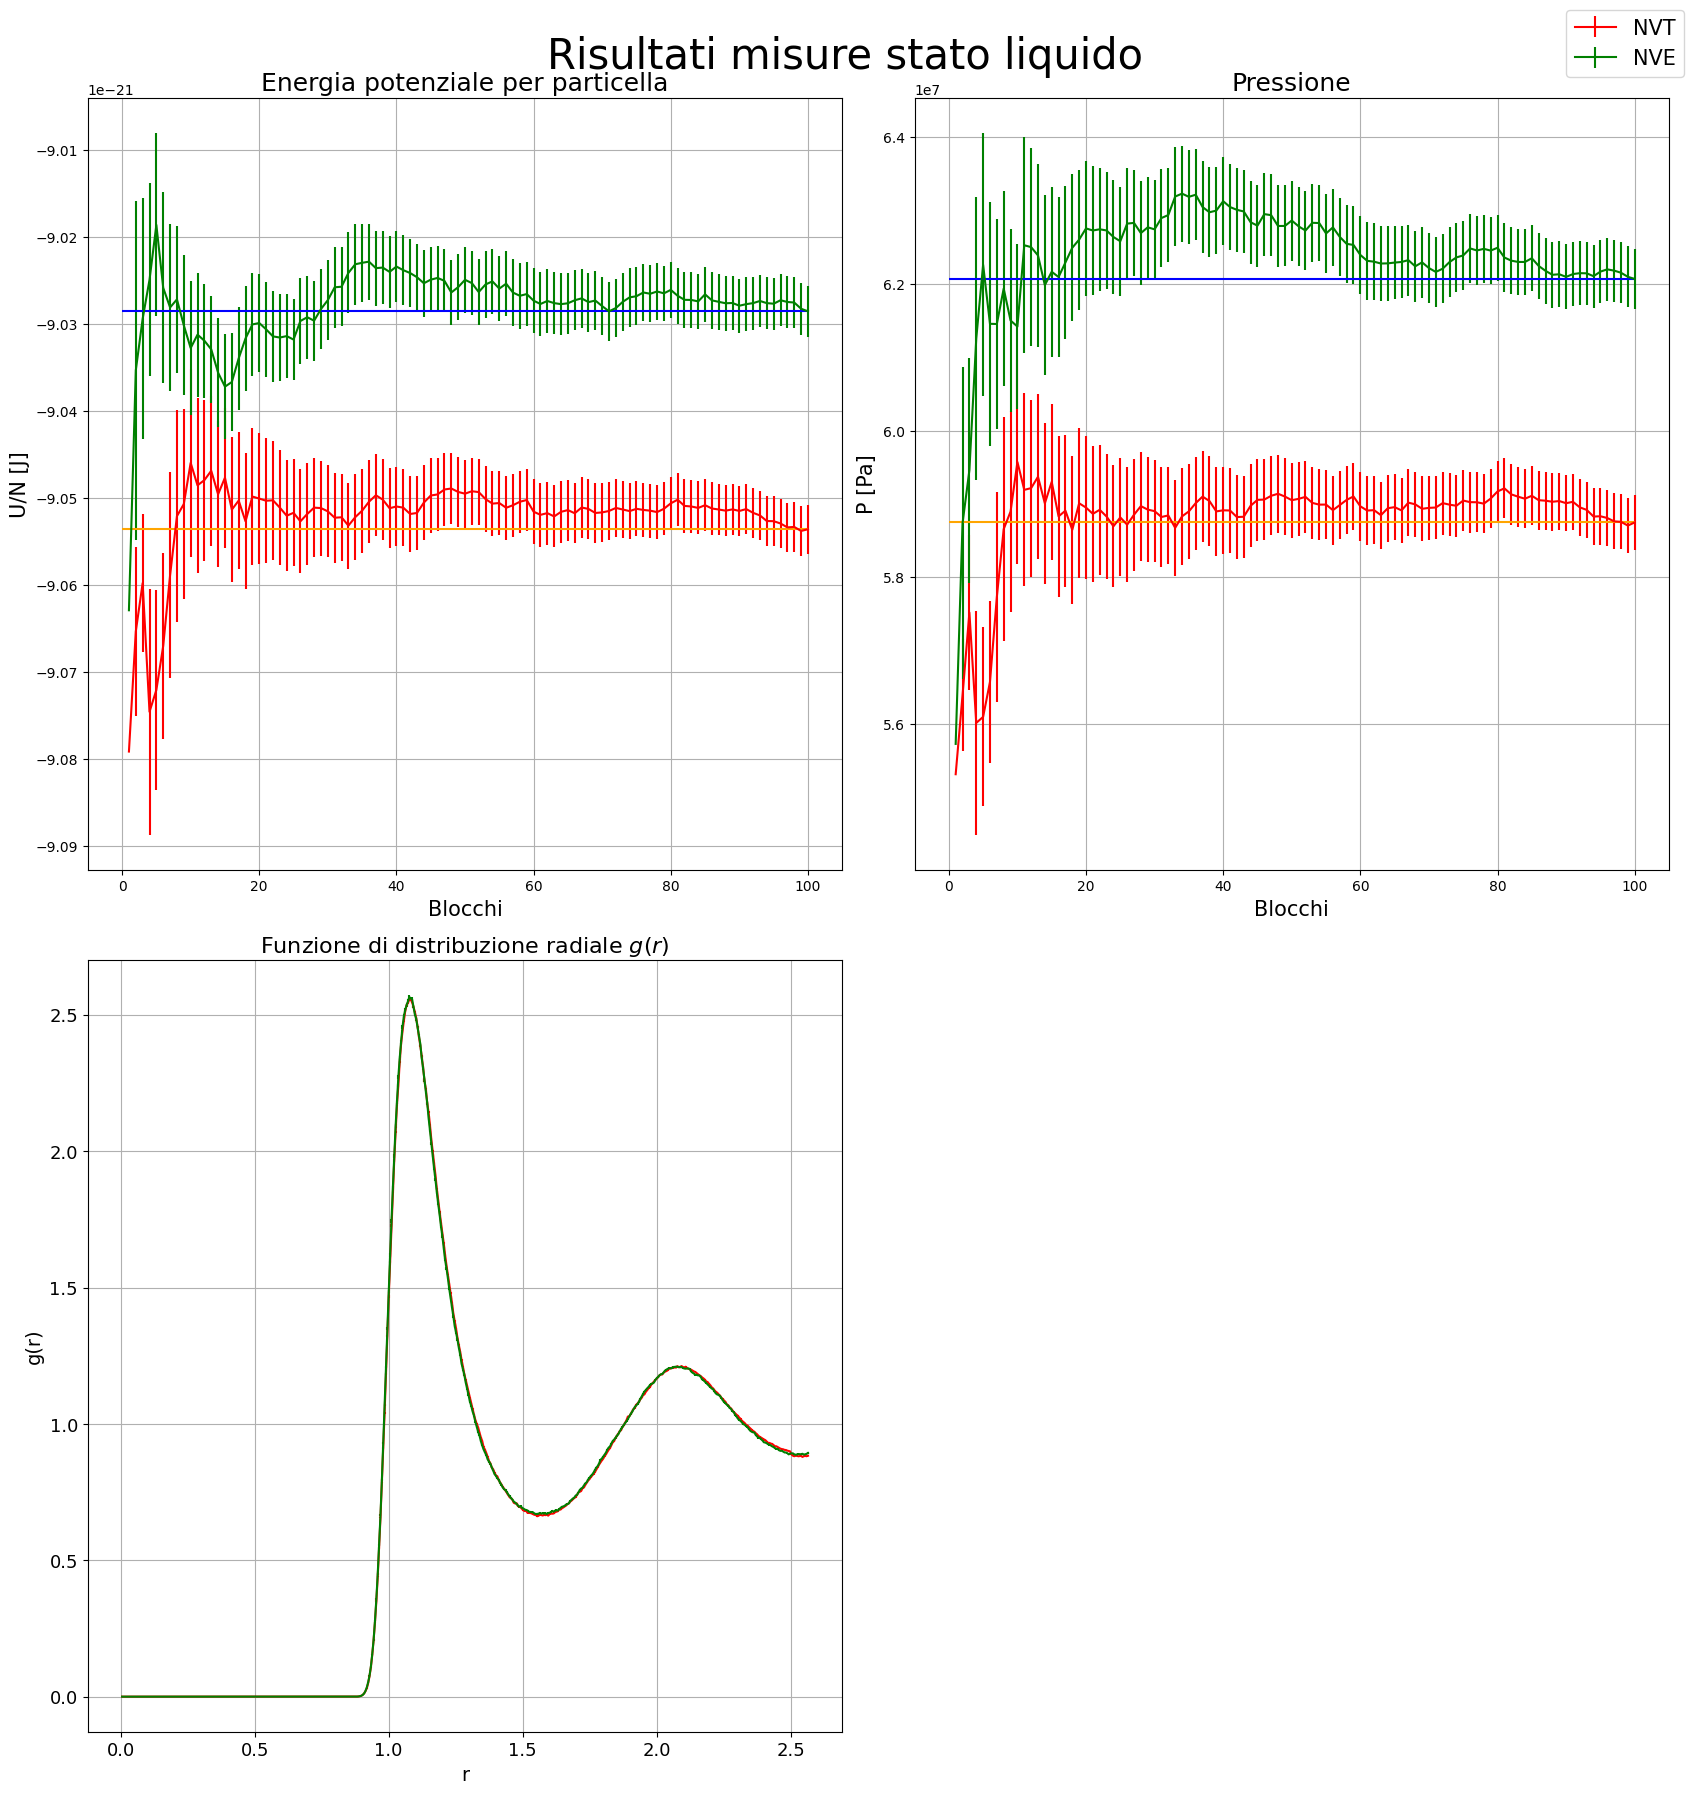

Differenza relativa energia NVE/NVT: -0.28 %
Differenza relativa pressione NVE/NVT: 5.65 %


In [13]:
N=len(T_U_liq) # number of blocks

# aggiungo le correzioni di coda a NVE
E_U_liq += tails["liquid"][0]
E_P_liq += tails["liquid"][1]

x = np.arange(1,N+1)

fig, axs = plt.subplots(2,2, figsize = (17,18))
fig.suptitle("Risultati misure stato liquido", fontsize = (30))

plt.subplot(2,2,1)
plt.errorbar(x, T_U_liq, yerr=T_err_U_liq, label = "NVT", color = "red")
plt.errorbar(x, E_U_liq, yerr=E_err_U_liq, label = "NVE", color = "green")
plt.title("Energia potenziale per particella", fontsize=18)
plt.xlabel("Blocchi", fontsize = 15)
plt.ylabel("U/N [J]", fontsize = 15)
plt.hlines(T_U_liq[-1], 0, N, color = "orange")
plt.hlines(E_U_liq[-1], 0, N, color = "blue")
plt.grid(True)
plt.tight_layout()

plt.subplot(2,2,2)
plt.errorbar(x, T_P_liq, yerr=T_err_P_liq, color = "red")
plt.errorbar(x, E_P_liq, yerr=E_err_P_liq, color = "green")
plt.title("Pressione", fontsize=18)
plt.xlabel("Blocchi", fontsize = 15)
plt.ylabel("P [Pa]", fontsize = 15)
plt.hlines(T_P_liq[-1], 0, N, color = "orange")
plt.hlines(E_P_liq[-1], 0, N, color = "blue")
plt.grid(True)
plt.tight_layout()

plt.subplot(2,2,3)
plt.title(r"Funzione di distribuzione radiale $g(r)$",fontsize=16)
plt.errorbar(T_r_liq, T_g_liq, yerr=T_err_g_liq , color = "red")
plt.errorbar(E_r_liq, E_g_liq, yerr=E_err_g_liq , color = "green")
plt.xlabel(r"r", fontsize=14)
plt.ylabel(r"g(r)", fontsize=14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid(True)
plt.tight_layout()

plt.subplot(2,2,4)
plt.axis("off")

fig.legend(fontsize = 15)


plt.show()

print(f"Differenza relativa energia NVE/NVT: {100*((E_U_liq[-1]-T_U_liq[-1])/T_U_liq[-1]):.2f} %")
print(f"Differenza relativa pressione NVE/NVT: {100*((E_P_liq[-1]-T_P_liq[-1])/T_P_liq[-1]):.2f} %")


Anche nel caso di stato liquido i due metodi sono compatibili. $\\$

Il caso gassoso, invece, è particolare perché il metodo NVE è stato svolto utilizzando $20$ blocchi invece di $100$, questo per una questione di potenza di calcolo.

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# carico U/N, P, g(r) misurata nei tre stati, sia per NVE che per NVT 
T_U_gas, T_err_U_gas = np.loadtxt("./Gas/NVT/output_epot.dat", unpack= True, usecols=(2, 3), skiprows=0) # NVT
E_U_gas, E_err_U_gas = np.loadtxt("./Gas/NVE/output_epot.dat", unpack= True, usecols=(2, 3), skiprows=0) # NVE

T_P_gas, T_err_P_gas = np.loadtxt("./Gas/NVT/output_pressure.dat", unpack= True, usecols=(2, 3), skiprows=0) # NVT
E_P_gas, E_err_P_gas = np.loadtxt("./Gas/NVE/output_pressure.dat", unpack= True, usecols=(2, 3), skiprows=0) # NVE

# converto in unità SI
T = 120 # temperatura [K]
k_b = 1.380649e-23 # costante di Boltzmann [J/K]
sigma = 0.34e-9 # sigma [m]

dati_U_gas = [T_U_gas, T_err_U_gas, E_U_gas, E_err_U_gas]
dati_P_gas = [T_P_gas, T_err_P_gas, E_P_gas, E_err_P_gas]

for U in dati_U_gas:
  U *= T*k_b
for P in dati_P_gas:
  P *= T*k_b/sigma**3


T_r_gas, T_g_gas, T_err_g_gas = np.loadtxt("./Gas/NVT/output_g_r.dat", unpack= True, usecols=(1, 2, 3), skiprows=49699) # NVT
E_r_gas, E_g_gas, E_err_g_gas = np.loadtxt("./Gas/NVE/output_g_r.dat", unpack= True, usecols=(1, 2, 3), skiprows=9539) # NVE

# Ora calcolo la differenza teorica di pressione ed energia corretti e non
# funzione per calcolare le correzioni
def Potential_tail_correction(rho, rcut):
  return (8./3.) * np.pi * rho *( 1./(3. * rcut**9) - 1./rcut**3) * T*k_b

def Pressure_tail_correction(rho, rcut):
  return (32./3.) * np.pi * rho * ( 1./(3.* rcut**9) - 1./(2.*rcut**3) ) * rho * T*k_b/sigma**3

# creo un dizionario in cui le chiavi sono li stati di aggregazione e i valori sono liste con rho e rcut di ognuno
states = {
  "solid": [1.1, 2.2],
  "liquid": [0.8, 2.5],
  "gas": [0.05, 5],
}

# creo un dizionario vuoto in cui salvare per ogni stato la correzione sul potenziale e sulla pressione
tails = {}

for state in states:
  vtail = Potential_tail_correction(*states[state]) # unpack degli ingressi
  ptail = Pressure_tail_correction(*states[state])
  tails[state] = [vtail, ptail]


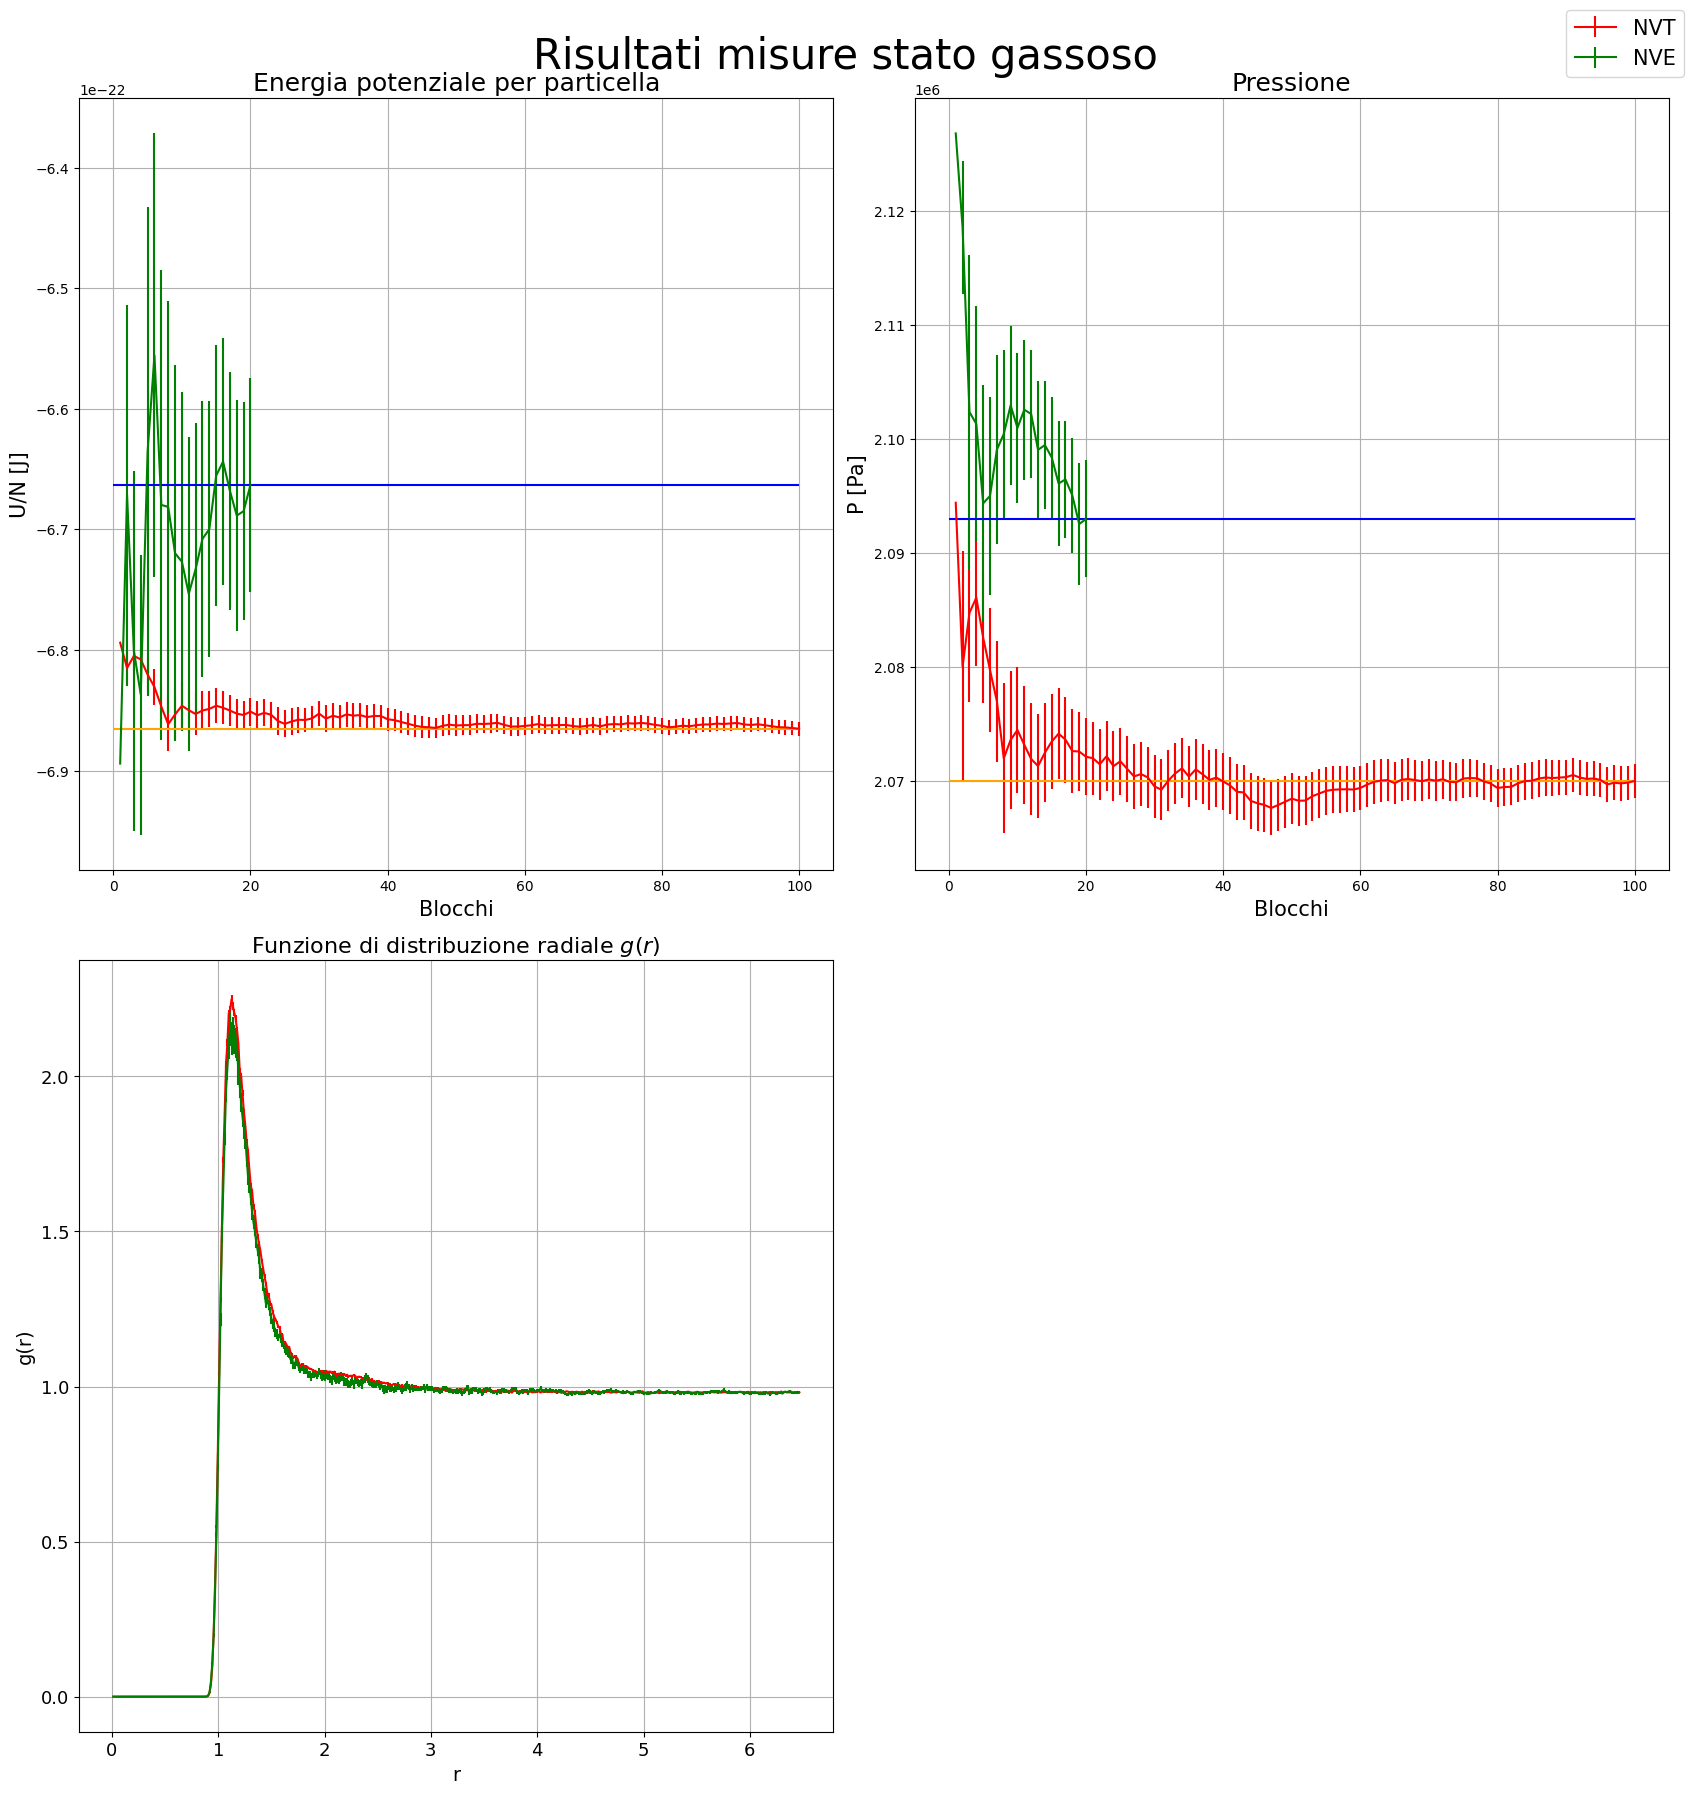

Differenza relativa energia NVE/NVT: -2.95 %
Differenza relativa pressione NVE/NVT: 1.11 %


In [15]:
N=len(T_U_gas) # number of blocks NVT
N_E=len(E_U_gas) # number of blocks NVE

# aggiungo le correzioni di coda a NVE
E_U_gas += tails["gas"][0]
E_P_gas += tails["gas"][1]

x = np.arange(1,N+1)
x_E = np.arange(1,N_E+1)


fig, axs = plt.subplots(2,2, figsize = (17,18))
fig.suptitle("Risultati misure stato gassoso", fontsize = (30))

plt.subplot(2,2,1)
plt.errorbar(x, T_U_gas, yerr=T_err_U_gas, label = "NVT", color = "red")
plt.errorbar(x_E, E_U_gas, yerr=E_err_U_gas, label = "NVE", color = "green")
plt.title("Energia potenziale per particella", fontsize=18)
plt.xlabel("Blocchi", fontsize = 15)
plt.ylabel("U/N [J]", fontsize = 15)
plt.hlines(T_U_gas[-1], 0, N, color = "orange")
plt.hlines(E_U_gas[-1], 0, N, color = "blue")
plt.grid(True)
plt.tight_layout()

plt.subplot(2,2,2)
plt.errorbar(x, T_P_gas, yerr=T_err_P_gas, color = "red")
plt.errorbar(x_E, E_P_gas, yerr=E_err_P_gas, color = "green")
plt.title("Pressione", fontsize=18)
plt.xlabel("Blocchi", fontsize = 15)
plt.ylabel("P [Pa]", fontsize = 15)
plt.hlines(T_P_gas[-1], 0, N, color = "orange")
plt.hlines(E_P_gas[-1], 0, N, color = "blue")
plt.grid(True)
plt.tight_layout()

plt.subplot(2,2,3)
plt.title(r"Funzione di distribuzione radiale $g(r)$",fontsize=16)
plt.errorbar(T_r_gas, T_g_gas, yerr=T_err_g_gas, color = "red")
plt.errorbar(E_r_gas, E_g_gas, yerr=E_err_g_gas, color = "green")
plt.xlabel(r"r", fontsize=14)
plt.ylabel(r"g(r)", fontsize=14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid(True)
plt.tight_layout()

plt.subplot(2,2,4)
plt.axis("off")

fig.legend(fontsize = 15)


plt.show()

print(f"Differenza relativa energia NVE/NVT: {100*((E_U_gas[-1]-T_U_gas[-1])/T_U_gas[-1]):.2f} %")
print(f"Differenza relativa pressione NVE/NVT: {100*((E_P_gas[-1]-T_P_gas[-1])/T_P_gas[-1]):.2f} %")


Nonostante il numero di blocchi fosse molto diverso, anche in questo ultimo stato si può constatare la riuscita del confronto tra i due metodo statistici.